<a href="https://colab.research.google.com/github/gaganmathur99/Apple_Counting_In_Orchard/blob/main/Apple_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Number of Apple in an image of Apple in an Orchards

Downloading Dataset from Source and Extracing locally

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!wget https://conservancy.umn.edu/bitstream/handle/11299/206575/detection.tar.gz?sequence=2&isAllowed=y

--2021-12-31 19:16:35--  https://conservancy.umn.edu/bitstream/handle/11299/206575/detection.tar.gz?sequence=2
Resolving conservancy.umn.edu (conservancy.umn.edu)... 128.101.122.105
Connecting to conservancy.umn.edu (conservancy.umn.edu)|128.101.122.105|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 1825397590 (1.7G) [application/gzip]
Saving to: ‘detection.tar.gz?sequence=2’

detection.tar.gz?se 100%[===================>]   1.70G  43.8MB/s    in 39s     

2021-12-31 19:17:14 (44.2 MB/s) - ‘detection.tar.gz?sequence=2’ saved [1825397590/1825397590]



In [ ]:
!tar --gunzip --extract --verbose --file=detection.tar.gz?sequence=2

detection/test/images/dataset2_back_630.png
detection/train/masks/20150919_174151_image11.png
detection/train/images/20150919_174730_image161.png
detection/train/masks/20150921_131346_image1121.png
detection/train/masks/20150921_131234_image546.png
detection/test/images/dataset3_front_510.png
detection/train/images/20150921_131346_image1121.png
detection/train/images/
detection/train/masks/20150921_132245_image396.png
detection/train/masks/20150921_131453_image676.png
detection/train/masks/20150921_131833_image296.png
detection/train/images/20150919_174151_image301.png
detection/train/images/20150921_132038_image76.png
detection/train/masks/20150921_131453_image1196.png
detection/train/images/20150921_131346_image51.png
detection/train/masks/20150921_132038_image1241.png
detection/test/images/dataset4_front_900.png
detection/test/images/dataset4_front_1020.png
detection/train/images/20150919_174730_image216.png
detection/train/images/20150921_131453_image1196.png
detection/train/images

Installing Required Libraries

In [ ]:
! pip install torch torchvision
! pip install matplotlib
! pip install opencv-contrib-python
! pip install imutils
! pip install scikit-learn
! pip install tqdm

Importing Required Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
import numpy as np
import torch

Generating List of image file names

In [ ]:
train_path = "/content/detection/train"
test_path = "/content/detection/test"

In [ ]:
train_image = list(sorted(os.listdir(os.path.join(train_path,"images"))))
train_mask = list(sorted(os.listdir(os.path.join(train_path,"masks"))))
test_image = list((os.listdir(os.path.join(test_path,"images"))))

dataset_length = len(train_image)
test_length = len(test_image)

In [ ]:
#Change to resize original image to size accordingly
img_width = 256
img_height = 256
img_channel = 3

In [ ]:
for i in range(10):
  print(train_image[i])

20150919_174151_image1.png
20150919_174151_image101.png
20150919_174151_image106.png
20150919_174151_image11.png
20150919_174151_image111.png
20150919_174151_image116.png
20150919_174151_image121.png
20150919_174151_image126.png
20150919_174151_image131.png
20150919_174151_image136.png


Generate Image Dataloader

In [ ]:
X_train = np.zeros((dataset_length,img_width, img_height,  img_channel), dtype = np.uint8)
Y_train = np.zeros((dataset_length,img_width, img_height,1), dtype = np.bool)

for idx in range(dataset_length):
  img_path = os.path.join(train_path,"images",train_image[idx])
  img = cv2.imread(img_path)[:,:,:img_channel]       
  img = cv2.resize(img, (img_height,img_width))
  X_train[idx] = img

  mask_ = np.zeros((img_width, img_height,1), dtype=np.bool)

  mask_path = os.path.join(train_path, "masks", train_mask[idx])
  mask = cv2.imread(mask_path)
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY) 
  (thresh, mask_b) = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)  
  mask_b = np.expand_dims(cv2.resize(mask_b, (img_height, img_width)),axis=-1)
  mask_=np.maximum(mask_,mask_b)
  Y_train[idx] = mask_

#Convert Mask into binary
Y_train_binary = 255*Y_train.astype(int)


Visualise Image and Mask

[  0 255]


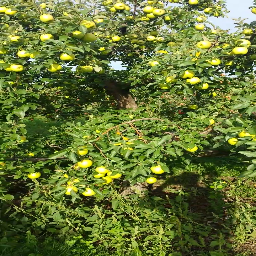

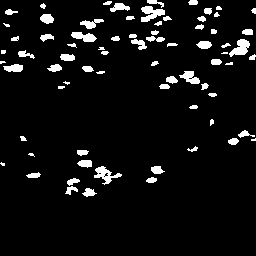

In [ ]:
from google.colab.patches import cv2_imshow

image_x = random.randint(0,dataset_length)
print(np.unique(Y_train_binary[idx]))
cv2_imshow(X_train[image_x])
plt.show()
cv2_imshow(np.squeeze(Y_train_binary[image_x]))
plt.show()





In [ ]:

def connected_component_analysis(images,bin_images,color,thickness):
  for j,img in enumerate(bin_images):
    output = cv2.connectedComponentsWithStats(np.uint8(img), 4, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    for i in range(1,numLabels):
      start_point = (stats[i,0],stats[i,1])
      end_point = (stats[i,0]+stats[i,2],stats[i,1]+stats[i,3])
      images[j] = cv2.rectangle(images[j], start_point, end_point, color, thickness)
      return images


In [ ]:
# Blue color in BGR
color = (255, 0, 0)
  
# Line thickness of 2 px
thickness = 2
X_train_bounding = connected_component_analysis(X_train,Y_train,color,thickness)

Connected Component Analysis to separate mask apple from image for VISUALISATION

[Info] examining component 1/75 (background)


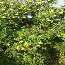

[Info] examining component 2/75


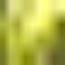

[Info] examining component 3/75


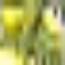

[Info] examining component 4/75


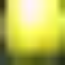

[Info] examining component 5/75


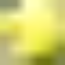

[Info] examining component 6/75


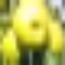

[Info] examining component 7/75


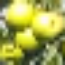

[Info] examining component 8/75


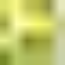

[Info] examining component 9/75


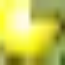

[Info] examining component 10/75


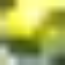

[Info] examining component 11/75


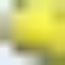

[Info] examining component 12/75


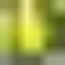

[Info] examining component 13/75


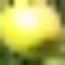

[Info] examining component 14/75


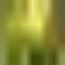

[Info] examining component 15/75


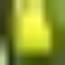

[Info] examining component 16/75


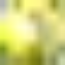

[Info] examining component 17/75


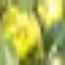

[Info] examining component 18/75


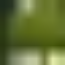

[Info] examining component 19/75


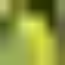

[Info] examining component 20/75


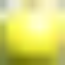

[Info] examining component 21/75


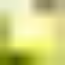

[Info] examining component 22/75


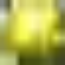

[Info] examining component 23/75


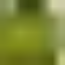

[Info] examining component 24/75


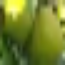

[Info] examining component 25/75


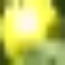

[Info] examining component 26/75


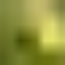

[Info] examining component 27/75


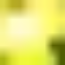

[Info] examining component 28/75


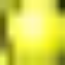

[Info] examining component 29/75


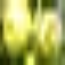

[Info] examining component 30/75


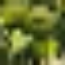

[Info] examining component 31/75


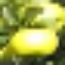

[Info] examining component 32/75


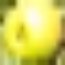

[Info] examining component 33/75


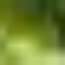

[Info] examining component 34/75


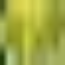

[Info] examining component 35/75


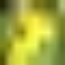

[Info] examining component 36/75


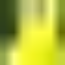

[Info] examining component 37/75


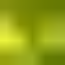

[Info] examining component 38/75


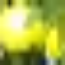

[Info] examining component 39/75


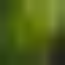

[Info] examining component 40/75


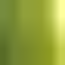

[Info] examining component 41/75


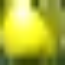

[Info] examining component 42/75


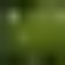

[Info] examining component 43/75


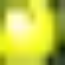

[Info] examining component 44/75


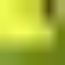

[Info] examining component 45/75


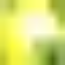

[Info] examining component 46/75


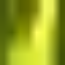

[Info] examining component 47/75


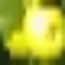

[Info] examining component 48/75


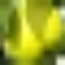

[Info] examining component 49/75


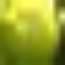

[Info] examining component 50/75


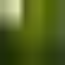

[Info] examining component 51/75


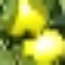

[Info] examining component 52/75


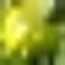

[Info] examining component 53/75


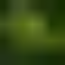

[Info] examining component 54/75


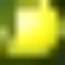

[Info] examining component 55/75


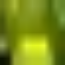

[Info] examining component 56/75


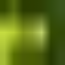

[Info] examining component 57/75


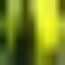

[Info] examining component 58/75


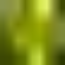

[Info] examining component 59/75


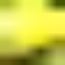

[Info] examining component 60/75


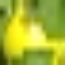

[Info] examining component 61/75


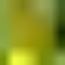

[Info] examining component 62/75


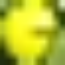

[Info] examining component 63/75


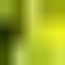

[Info] examining component 64/75


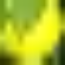

[Info] examining component 65/75


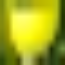

[Info] examining component 66/75


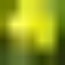

[Info] examining component 67/75


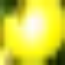

[Info] examining component 68/75


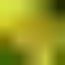

[Info] examining component 69/75


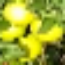

[Info] examining component 70/75


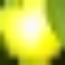

[Info] examining component 71/75


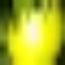

[Info] examining component 72/75


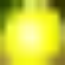

[Info] examining component 73/75


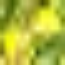

[Info] examining component 74/75


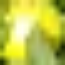

[Info] examining component 75/75


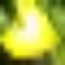

In [ ]:
output = cv2.connectedComponentsWithStats(np.uint8(Y_train[image_x]), 8, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output

for i in range(numLabels):
  if i==0:
    text = "examining component {}/{} (background)".format(i + 1, numLabels)
  else:
    text = "examining component {}/{}".format(i + 1, numLabels)
  print("[Info] {}".format(text) )
  x = stats[i, cv2.CC_STAT_LEFT]
  y = stats[i, cv2.CC_STAT_TOP]
  w = stats[i, cv2.CC_STAT_WIDTH]
  h = stats[i, cv2.CC_STAT_HEIGHT]
  output = X_train[image_x].copy()
  crop_img = output[y:y+h, x:x+w]
  crop_img = cv2.resize(crop_img, (65, 65))
  cv2_imshow(crop_img)
  cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
  componentMask = (labels == i).astype("uint8") * 255

#U-Net Model for Apple Segmentation

In [ ]:
import tensorflow as tf


inputs = tf.keras.layers.Input((img_width,img_height,img_channel))
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs) #Normalising and converting image into floating point

#Contracting Path
c1 = tf.keras.layers.Conv2D(16,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)


#Expansive Path
u6 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding="same")(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(128,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

u7 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding="same")(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
c7 = tf.keras.layers.Dropout(0.1)(c7)
c7 = tf.keras.layers.Conv2D(64,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)


u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding="same")(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)


u9 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding="same")(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis = 3)
c9 = tf.keras.layers.Conv2D(16,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)


outputs = tf.keras.layers.Conv2D(1,(1,1), activation="sigmoid")(c9)

model = tf.keras.Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  448         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint("Apple_detection.h5", verbose=1, save_best_only=True)

callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir="logs")]

In [ ]:
results = model.fit(X_train, Y_train, validation_split = 0.1, batch_size=32, epochs=25, callbacks=callbacks )

Epoch 1/25
19/19 [==============================] - 430s 23s/step - loss: 0.2380 - accuracy: 0.9712 - val_loss: 0.1019 - val_accuracy: 0.9841
Epoch 2/25
19/19 [==============================] - 440s 23s/step - loss: 0.1630 - accuracy: 0.9720 - val_loss: 0.0914 - val_accuracy: 0.9841
Epoch 3/25
19/19 [==============================] - 447s 24s/step - loss: 0.1267 - accuracy: 0.9720 - val_loss: 0.0791 - val_accuracy: 0.9841
Epoch 4/25
19/19 [==============================] - 446s 23s/step - loss: 0.0959 - accuracy: 0.9720 - val_loss: 0.0779 - val_accuracy: 0.9844
Epoch 5/25
19/19 [==============================] - 444s 23s/step - loss: 0.0782 - accuracy: 0.9729 - val_loss: 0.0537 - val_accuracy: 0.9861
Epoch 6/25
19/19 [==============================] - 428s 23s/step - loss: 0.0678 - accuracy: 0.9763 - val_loss: 0.0478 - val_accuracy: 0.9834
Epoch 7/25
19/19 [==============================] - 438s 23s/step - loss: 0.0616 - accuracy: 0.9794 - val_loss: 0.0556 - val_accuracy: 0.9796
Epoch 

Save and Load for future *use*

In [ ]:
!mkdir -p saved_model_Segmentation
model.save('/content/gdrive/MyDrive/Colab Notebooks/ML Tutorial/saved_model_Segmentation/Apple_segmentation')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ML Tutorial/saved_model_Segmentation/Apple_segmentation/assets


In [ ]:
new_model_segmentation = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/ML Tutorial/saved_model_Segmentation/Apple_segmentation')

# Check its architecture
new_model_segmentation.summary()

#Visualise Segmentation Results

In [ ]:
idx = random.randint(0,len(X_train))

In [ ]:
preds_train = new_model_segmentation.predict(X_train[:int(X_train.shape[0]*0.9)])

In [ ]:
preds_train = (preds_train>0.5).astype(np.uint8)

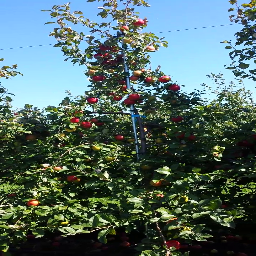

Image


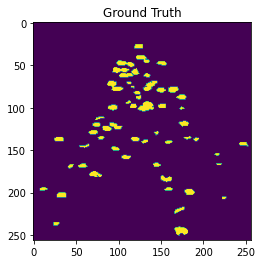

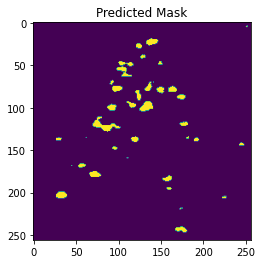

In [ ]:
ix = random.randint(0,len(preds_train))
cv2_imshow(X_train[ix])
print("Image")
plt.show()
plt.imshow(np.squeeze(Y_train[ix]))
plt.title("Ground Truth")
plt.show()
plt.imshow(np.squeeze(preds_train[ix]))
plt.title("Predicted Mask")
plt.show()

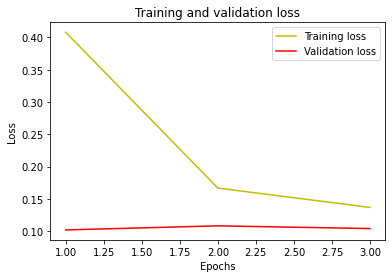

In [ ]:
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
X_test = np.zeros((test_length,img_width, img_height,  img_channel), dtype = np.uint8)

for idx in range(test_length):
  img_path = os.path.join(test_path,"images",test_image[idx])
  img = cv2.imread(img_path)[:,:,:img_channel]       
  img = cv2.resize(img, (img_height,img_width))
  X_test[idx] = img


In [ ]:
preds_test = new_model_segmentation.predict(X_test[:int(X_test.shape[0]*0.9)])
# preds_val = new_model_segmentation.predict(X_train[int(X_train.shape[0]*0.9:)])

In [ ]:
preds_test_t = (preds_test>0.5).astype(np.uint8)

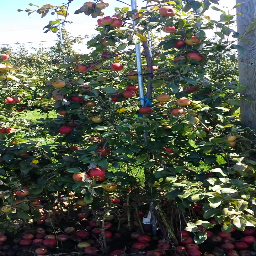

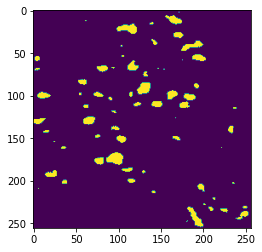

In [ ]:
ix = random.randint(0,len(preds_test_t))
cv2_imshow(X_test[ix])
plt.show()

plt.imshow(np.squeeze(preds_test_t[ix]))
plt.show()

#Loading a Counting Model from drive 

In [ ]:
new_model_counting = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/ML Tutorial/saved_model/Apple_counting')

# Check its architecture
new_model_counting.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 65, 65, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 65, 65, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 65, 65, 16)        448       
                                                                 
 dropout (Dropout)           (None, 65, 65, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                             

#Results

Calculating Total Apples in an image using U-Net Semantic Segmantation and Classification Counting Network

[Info] examining component 1/68 (background)


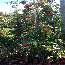

[Info] examining component 2/68


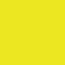

1
[Info] examining component 3/68


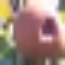

1
[Info] examining component 4/68


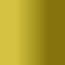

2
[Info] examining component 5/68


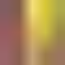

2
[Info] examining component 6/68


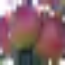

2
[Info] examining component 7/68


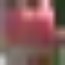

2
[Info] examining component 8/68


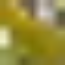

2
[Info] examining component 9/68


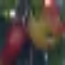

3
[Info] examining component 10/68


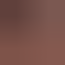

2
[Info] examining component 11/68


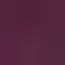

1
[Info] examining component 12/68


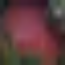

1
[Info] examining component 13/68


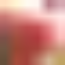

1
[Info] examining component 14/68


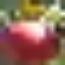

1
[Info] examining component 15/68


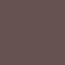

2
[Info] examining component 16/68


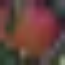

2
[Info] examining component 17/68


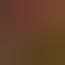

2
[Info] examining component 18/68


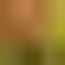

4
[Info] examining component 19/68


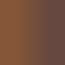

2
[Info] examining component 20/68


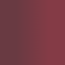

2
[Info] examining component 21/68


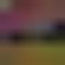

3
[Info] examining component 22/68


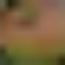

2
[Info] examining component 23/68


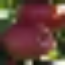

1
[Info] examining component 24/68


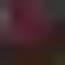

1
[Info] examining component 25/68


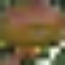

3
[Info] examining component 26/68


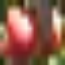

1
[Info] examining component 27/68


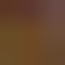

2
[Info] examining component 28/68


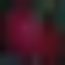

1
[Info] examining component 29/68


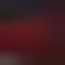

1
[Info] examining component 30/68


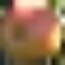

1
[Info] examining component 31/68


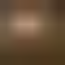

1
[Info] examining component 32/68


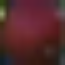

1
[Info] examining component 33/68


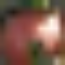

2
[Info] examining component 34/68


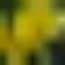

3
[Info] examining component 35/68


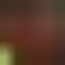

1
[Info] examining component 36/68


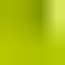

1
[Info] examining component 37/68


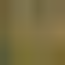

4
[Info] examining component 38/68


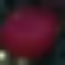

1
[Info] examining component 39/68


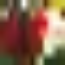

1
[Info] examining component 40/68


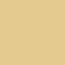

0
[Info] examining component 41/68


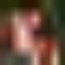

1
[Info] examining component 42/68


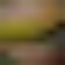

3
[Info] examining component 43/68


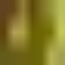

2
[Info] examining component 44/68


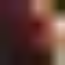

1
[Info] examining component 45/68


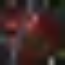

1
[Info] examining component 46/68


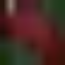

1
[Info] examining component 47/68


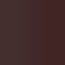

1
[Info] examining component 48/68


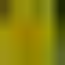

2
[Info] examining component 49/68


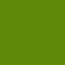

0
[Info] examining component 50/68


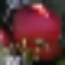

1
[Info] examining component 51/68


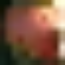

1
[Info] examining component 52/68


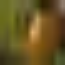

2
[Info] examining component 53/68


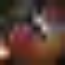

1
[Info] examining component 54/68


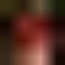

1
[Info] examining component 55/68


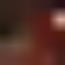

1
[Info] examining component 56/68


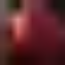

2
[Info] examining component 57/68


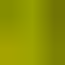

4
[Info] examining component 58/68


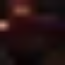

1
[Info] examining component 59/68


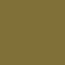

4
[Info] examining component 60/68


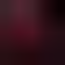

1
[Info] examining component 61/68


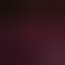

1
[Info] examining component 62/68


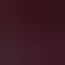

1
[Info] examining component 63/68


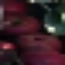

1
[Info] examining component 64/68


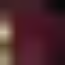

1
[Info] examining component 65/68


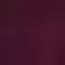

1
[Info] examining component 66/68


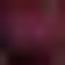

1
[Info] examining component 67/68


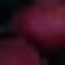

2
[Info] examining component 68/68


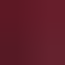

1


In [ ]:
output = cv2.connectedComponentsWithStats(np.uint8(np.squeeze(preds_test_t[ix])), 8, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output
Total=0
for i in range(numLabels):
  X_ans=[]
  if i==0:
    text = "examining component {}/{} (background)".format(i + 1, numLabels)
  else:
    text = "examining component {}/{}".format(i + 1, numLabels)
  print("[Info] {}".format(text) )
  x = stats[i, cv2.CC_STAT_LEFT]
  y = stats[i, cv2.CC_STAT_TOP]
  w = stats[i, cv2.CC_STAT_WIDTH]
  h = stats[i, cv2.CC_STAT_HEIGHT]
  output = X_test[ix].copy()
  crop_img = output[y:y+h, x:x+w]
  crop_img = cv2.resize(crop_img, (65, 65))
  cv2_imshow(crop_img)
  cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
  componentMask = (labels == i).astype("uint8") * 255
  if i!=0:
    X_ans.append(crop_img)
    X_ans = np.array(X_ans)
    preds_test = new_model_counting.predict(X_ans)
    print(np.argmax(preds_test))
    Total+=np.argmax(preds_test)


Total Apples in an Orchard

In [ ]:
print(Total)

106
